<a href="https://colab.research.google.com/github/zhestyatsky/mipt-opt-project/blob/dev/src/spider_boost_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import sys
import random

In [0]:
def gradient_descent(x, y, model, loss, regularizer, lr, n_iters, samples_num):
    total_loss = np.zeros(n_iters)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    mask_helper = range(y.shape[0])
    
    for k in range(n_iters):
        y_pred = model(x)
        sample = random.sample(mask_helper, samples_num)
        
        # Calculate sample loss and regularizer loss
        sample_loss = loss(y_pred[sample], y[sample])
        reg_loss = regularizer(model.parameters())
        sample_loss += reg_loss
        sample_loss.backward()
        
        # Save total loss
        total_loss[k] = loss(y_pred, y).item() + reg_loss.item()
        
        # Optimize
        optimizer.step()
        optimizer.zero_grad()

        if k % 100 == 0:
          print(f'iter:{k}')

    return total_loss

In [0]:
def spider_boost(x, y, model, model_prev, loss, regularizer, lr, q, n_iters, samples_num):
    total_loss = np.zeros(n_iters)
    
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    opt_prev = torch.optim.SGD(model_prev.parameters(), lr=lr)
    
    mask_helper = range(y.shape[0])
    
    for k in range(n_iters):
        if k % q == 0:
            # Calculating fool gradient
            opt.zero_grad()
            y_pred = model(x)
            
            # Calculate total loss
            main_loss = loss(y_pred, y) + regularizer(model.parameters())
            main_loss.backward()
            total_loss[k] = main_loss.item()
            
            # Saving current model state and zero grad it
            for param, param_prev in zip(model.parameters(), model_prev.parameters()):
                param_prev.data = param.data.clone().detach()
            opt_prev.zero_grad()
            
            opt.step()
        else:
            sample = random.sample(mask_helper, samples_num)
            
            # Add positive sample gradients
            y_pred = model(x)
            sample_loss = loss(y_pred[sample], y[sample])
            reg_loss = regularizer(model.parameters())
            sample_loss += reg_loss
            sample_loss.backward()
            
            # Calculate sample gradients of previous state
            y_pred_prev = model_prev(x)
            sample_loss_prev = loss(y_pred_prev[sample], y[sample])
            sample_loss_prev.backward()
            
            # Subtract those gradients from current gradients and save current satae
            for param, param_prev in zip(model.parameters(), model_prev.parameters()):
                param.grad.data -= param_prev.grad.data
                param_prev.data = param.data.clone().detach()
            opt_prev.zero_grad()
            
            # Save total loss
            total_loss[k] = loss(y_pred, y).item() + reg_loss.item()
            
            opt.step()
        if k % 100 == 0:
            print(f'iter:{k}')
    return total_loss

In [0]:
train_dataset = dsets.MNIST(root='~/.pytorch/MNIST_data/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=True)

In [0]:
images, labels = next(iter(train_loader))
images = images.view(-1, 28 * 28).cuda()
labels = labels.cuda()

In [0]:
learning_rate = 0.001
q = 20
n_iters = 5000
samples_num = 32

In [0]:
loss = torch.nn.CrossEntropyLoss().cuda()
def regularizer(parameters, alpha=0.1):
    value = 0.0
    for p in parameters:
        value += alpha * (p**2 / (1 + p**2)).sum()
    return value

In [0]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

class CustomModel(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CustomModel, self).__init__()
        self.conv1 = torch.nn.Linear(input_dim, 1000)
        self.conv2 = torch.nn.Linear(1000, 2000)
        self.conv3 = torch.nn.Linear(2000, output_dim)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv3(x)
        outputs = torch.sigmoid(x)
        return outputs
    
gd_model = CustomModel(784, 10).cuda()
sb_model = copy.deepcopy(gd_model).cuda()
sb_model_prev = copy.deepcopy(gd_model).cuda()

gd_total_loss = gradient_descent(images, labels, gd_model, loss, regularizer, learning_rate, n_iters, samples_num)
sp_boost_total_loss = spider_boost(images, labels, sb_model, sb_model_prev, loss, regularizer, learning_rate, q, n_iters, samples_num)

iter:0
iter:100
iter:200
iter:300
iter:400
iter:500
iter:600
iter:700
iter:800
iter:900
iter:1000
iter:1100
iter:1200
iter:1300
iter:1400
iter:1500
iter:1600
iter:1700
iter:1800
iter:1900
iter:2000
iter:2100
iter:2200
iter:2300
iter:2400
iter:2500
iter:2600
iter:2700
iter:2800
iter:2900
iter:3000
iter:3100
iter:3200
iter:3300
iter:3400
iter:3500
iter:3600
iter:3700
iter:3800
iter:3900
iter:4000
iter:4100
iter:4200
iter:4300
iter:4400
iter:4500
iter:4600
iter:4700
iter:4800
iter:4900
iter:0
iter:100
iter:200
iter:300
iter:400
iter:500
iter:600
iter:700
iter:800
iter:900
iter:1000
iter:1100
iter:1200
iter:1300
iter:1400
iter:1500
iter:1600
iter:1700
iter:1800
iter:1900
iter:2000
iter:2100
iter:2200
iter:2300
iter:2400
iter:2500
iter:2600
iter:2700
iter:2800
iter:2900
iter:3000
iter:3100
iter:3200
iter:3300
iter:3400
iter:3500
iter:3600
iter:3700
iter:3800
iter:3900
iter:4000
iter:4100
iter:4200
iter:4300
iter:4400
iter:4500
iter:4600
iter:4700
iter:4800
iter:4900


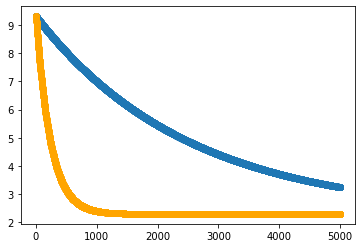

In [0]:
# With 2 layers: 784 : 200 -> 200 : 10
plt.scatter(np.arange(n_iters), gd_total_loss)
plt.scatter(np.arange(n_iters), sp_boost_total_loss, color='orange')
plt.show()

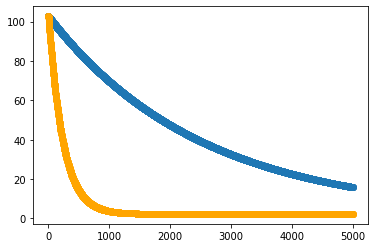

In [0]:
# With 3 layers: 784 : 1000 -> 1000 : 2000 -> 2000 : 10
plt.scatter(np.arange(n_iters), gd_total_loss)
plt.scatter(np.arange(n_iters), sp_boost_total_loss, color='orange')
plt.show()